# **Classification on the ‘credit-g’ dataset using SVM**


In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on Colab')
else:
    print('Not Running on Colab')


Running on Colab


In [ ]:
if 'google.colab' in str(get_ipython()):
  !pip install --upgrade feature_engine scikit-learn -q
  from google.colab import drive
  drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.8 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
"""Importing the required packages"""

# For DataFrames and manipulations
import pandas as pd
import numpy as np

# For data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# save and load models
import joblib

# Pathlib to navigate file system
from pathlib import Path
import sys

# For splitting the dataset
from sklearn.model_selection import train_test_split,StratifiedKFold

# For categorical variables
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder

# For scaling the data
from sklearn.preprocessing import StandardScaler

# creating pipelines
from sklearn.pipeline import Pipeline

# Hyper parameter tuning
from sklearn.model_selection import GridSearchCV

# Using KNN classification for our data
from sklearn.neighbors import KNeighborsClassifier

# draws a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# We will use this to download the Dataset
from sklearn.datasets import fetch_openml

# feature engine log transformation
from feature_engine.transformation import LogTransformer

# feature engine wrapper
from feature_engine.wrappers import SklearnTransformerWrapper

from feature_engine.encoding import DecisionTreeEncoder
# Using Support Vector Machines as models
from sklearn.svm import LinearSVC
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from scipy.stats import uniform, truncnorm, randint, loguniform
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.selection import DropFeatures
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine import transformation as vt
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import power_transform

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [ ]:
base_folder = Path('/content/drive/MyDrive/AML/data')
data_folder = base_folder/'datasets'
save_model_folder = base_folder/'models/ml_fall_2023'
custom_function_folder = base_folder/'custom-functions'
save_model_folder.mkdir(exist_ok=True, parents=True)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
sys.path.append(str(custom_function_folder))


In [ ]:
!cp /content/drive/MyDrive/plot_learning_curve.py .
from  plot_learning_curve import plot_learning_curve

In [ ]:
!cp /content/drive/MyDrive/eda_plots.py .
from eda_plots import diagnostic_plots, plot_target_by_category

# Download Data:
You can download the dataset using the commands below  and see it’s description at https://www.openml.org/d/31

### Attribute description from https://www.openml.org/d/31

1. Status of existing checking account, in Deutsche Mark.
2. Duration in months
3. Credit history (credits taken, paid back duly, delays, critical accounts)
4. Purpose of the credit (car, television,...)
5. Credit amount
6. Status of savings account/bonds, in Deutsche Mark.
7. Present employment, in number of years.
8. Installment rate in percentage of disposable income
9. Personal status (married, single,...) and sex
10. Other debtors / guarantors
11. Present residence since X years
12. Property (e.g. real estate)
13. Age in years
14. Other installment plans (banks, stores)
15. Housing (rent, own,...)
16. Number of existing credits at this bank
17. Job
18. Number of people being liable to provide maintenance for
19. Telephone (yes,no)
20. Foreign worker (yes,no)

In [ ]:
# Load data from  https://www.openml.org/d/31
X, y = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123, stratify =y)
var_rare_labels= [
'credit_history',
'purpose',
'savings_status',
'personal_status',
'other_parties',
'other_payment_plans',
'job',
]


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class ConvertToNumpyArray(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return np.array(X)


In [ ]:
# Create a list of categorical variables
# Since the dtype of categorical variable is Object we can compare the values with 'O'
categorical = [var for var in X.columns if X[var].dtype.name == 'category']

# Create a list of discrete variables
# we do not want to consider Exited as this is target variable
discrete = [
    var for var in X.columns if X[var].dtype.name != 'category'
    and len(X[var].unique()) < 20
]

# Create a list of continuous Variables
continuous = [
    var for var in X.columns if X[var].dtype.name != 'category'
    if var not in discrete
]

In [ ]:
credit_risk_pipeline_1 = Pipeline([
('rare_label_encoder',
RareLabelEncoder(variables=var_rare_labels,replace_with='Rare')),
('one_hot_encoder',
OneHotEncoder(variables=categorical,drop_last= True, ignore_format=True)),
('log_transformer',
LogTransformer(variables = continuous)),
('scalar',
SklearnTransformerWrapper(StandardScaler(),variables=continuous)),
('convert_to_numpy', ConvertToNumpyArray()),
('svc',
SVC(kernel = 'poly',random_state=123, max_iter =100000))
])


In [ ]:
from sklearn import set_config

set_config(display='diagram')
credit_risk_pipeline_1

Pipeline(steps=[('rare_label_encoder',
                 RareLabelEncoder(variables=['credit_history', 'purpose',
                                             'savings_status',
                                             'personal_status', 'other_parties',
                                             'other_payment_plans', 'job'])),
                ('one_hot_encoder',
                 OneHotEncoder(drop_last=True, ignore_format=True,
                               variables=['checking_status', 'credit_history',
                                          'purpose', 'savings_status',
                                          'employment', 'personal_status',
                                          'oth...
                                          'other_payment_plans', 'housing',
                                          'job', 'own_telephone',
                                          'foreign_worker'])),
                ('log_transformer',
                 LogTransformer(variables=['duration', 'credit_amount',
                                           'age'])),
                ('scalar',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['duration',
                                                      'credit_amount',
                                                      'age'])),
                ('convert_to_numpy', ConvertToNumpyArray()),
                ('svc', SVC(kernel='poly', max_iter=100000, random_state=123))])

In [ ]:
credit_risk_pipeline_1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'rare_label_encoder', 'one_hot_encoder', 'log_transformer', 'scalar', 'convert_to_numpy', 'svc', 'rare_label_encoder__ignore_format', 'rare_label_encoder__max_n_categories', 'rare_label_encoder__missing_values', 'rare_label_encoder__n_categories', 'rare_label_encoder__replace_with', 'rare_label_encoder__tol', 'rare_label_encoder__variables', 'one_hot_encoder__drop_last', 'one_hot_encoder__drop_last_binary', 'one_hot_encoder__ignore_format', 'one_hot_encoder__top_categories', 'one_hot_encoder__variables', 'log_transformer__base', 'log_transformer__variables', 'scalar__transformer__copy', 'scalar__transformer__with_mean', 'scalar__transformer__with_std', 'scalar__transformer', 'scalar__variables', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__v

In [ ]:
param_grid_1 = {
    'scalar__transformer': [StandardScaler(), MinMaxScaler()],
    'svc__C': [1,10,20,30,40,50,80,100,200,300],
    'svc__kernel':['poly','rbf']   #trying poly and rbf kernels in the same pipeline
    }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# now we set up the grid search with cross-validation
grid_svc_1 = HalvingGridSearchCV(credit_risk_pipeline_1,param_grid_1,resource='n_samples',factor=2,random_state= 123, cv= cv, return_train_score= True)

In [ ]:
grid_svc_1.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable job is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable credit_history is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable purpose is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable savings_status is less th

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                    estimator=Pipeline(steps=[('rare_label_encoder',
                                               RareLabelEncoder(variables=['credit_history',
                                                                           'purpose',
                                                                           'savings_status',
                                                                           'personal_status',
                                                                           'other_parties',
                                                                           'other_payment_plans',
                                                                           'job'])),
                                              ('one_hot_encoder',
                                               OneHotEncoder(drop_last=True,
                                                             ignore_format=True,
                                                             variables=['checki...
                                               SklearnTransformerWrapper(transformer=StandardScaler(),
                                                                         variables=['duration',
                                                                                    'credit_amount',
                                                                                    'age'])),
                                              ('convert_to_numpy',
                                               ConvertToNumpyArray()),
                                              ('svc',
                                               SVC(kernel='poly',
                                                   max_iter=100000,
                                                   random_state=123))]),
                    factor=2,
                    param_grid={'scalar__transformer': [StandardScaler(),
                                                        MinMaxScaler()],
                                'svc__C': [1, 10, 20, 30, 40, 50, 80, 100, 200,
                                           300],
                                'svc__kernel': ['poly', 'rbf']},
                    random_state=123)

In [ ]:
print(grid_svc_1.best_params_)

{'scalar__transformer': MinMaxScaler(), 'svc__C': 1, 'svc__kernel': 'poly'}


In [ ]:
file_best_estimator_round1 = save_model_folder / 'svc_round1_best_estimator.pkl'
file_complete_grid_round1  = save_model_folder / 'svc_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_svc_1.best_estimator_, file_best_estimator_round1 )
joblib.dump(grid_svc_1, file_complete_grid_round1)

['/content/drive/MyDrive/AML/data/models/ml_fall_2023/svc_round1_complete_grid.pkl']

In [ ]:
loaded_best_estimator_round1 = joblib.load(file_best_estimator_round1)
loaded_complete_grid_round1 = joblib.load(file_complete_grid_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

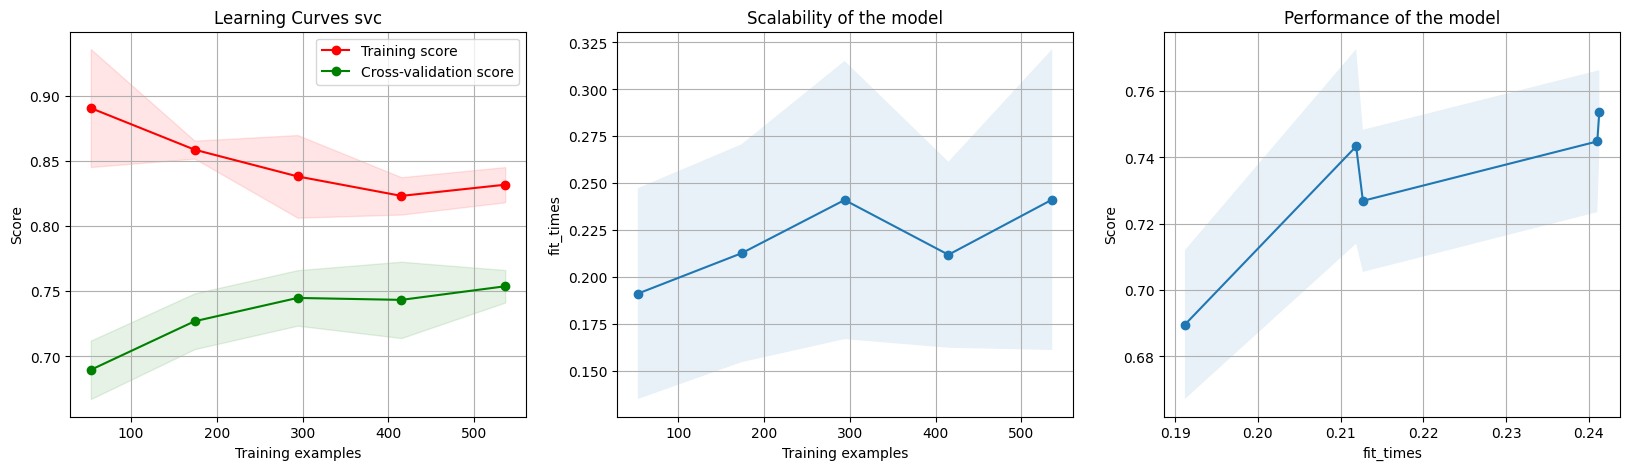

In [ ]:
plot_learning_curve(loaded_best_estimator_round1, 'Learning Curves svc', X_train, y_train, n_jobs=-1)

In [ ]:
#let's check the train scores
print(loaded_best_estimator_round1.score(X_train,y_train))

#let's check the cross validation score
print(loaded_complete_grid_round1.best_score_)

0.8253731343283582
0.7453125


<font size=6> **ROUND 2**

In [ ]:
param_grid_2 = [{
    'scalar__transformer': [StandardScaler(), MinMaxScaler()],
    'svc__kernel' :['rbf'],
    'svc__C' :[1,5,10,20,30,50,80,100,200,300],
    'svc__gamma' :loguniform(0.01, 10),
     },
     {
    'scalar__transformer': [StandardScaler(), MinMaxScaler()],
    'svc__kernel' :['poly'],
    'svc__C' :[1,5,10,20,30,50,80,100,200,300],
    'svc__gamma' :loguniform(0.01, 10),
    'svc__degree' : [2,3,4,5],
     }]

In [ ]:
grid_svc_2 = HalvingRandomSearchCV(credit_risk_pipeline_1, param_grid_2,
                           cv=cv, factor = 3, resource='n_samples',random_state=123, return_train_score= True)

In [ ]:
grid_svc_2.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable credit_history is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable purpose is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable savings_status is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable personal_status is less than that indicated in n_categories. Thus

HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                      estimator=Pipeline(steps=[('rare_label_encoder',
                                                 RareLabelEncoder(variables=['credit_history',
                                                                             'purpose',
                                                                             'savings_status',
                                                                             'personal_status',
                                                                             'other_parties',
                                                                             'other_payment_plans',
                                                                             'job'])),
                                                ('one_hot_encoder',
                                                 OneHotEncoder(drop_last=True,
                                                               ignore_format=True,
                                                               variables=['chec...
                                            'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c456974d6f0>,
                                            'svc__kernel': ['rbf']},
                                           {'scalar__transformer': [StandardScaler(),
                                                                    MinMaxScaler()],
                                            'svc__C': [1, 5, 10, 20, 30, 50, 80,
                                                       100, 200, 300],
                                            'svc__degree': [2, 3, 4, 5],
                                            'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c456974c970>,
                                            'svc__kernel': ['poly']}],
                      random_state=123)

In [ ]:
print(grid_svc_2.best_params_)

{'scalar__transformer': MinMaxScaler(), 'svc__C': 20, 'svc__degree': 4, 'svc__gamma': 0.017831154117152484, 'svc__kernel': 'poly'}


In [ ]:
file_best_estimator_round2 = save_model_folder / 'svc_round2_best_estimator.pkl'
file_complete_grid_round2 = save_model_folder / 'svc_round2_complete_grid.pkl'

In [ ]:
joblib.dump(grid_svc_2.best_estimator_, file_best_estimator_round2)
joblib.dump(grid_svc_2, file_complete_grid_round2)


['/content/drive/MyDrive/AML/data/models/ml_fall_2023/svc_round2_complete_grid.pkl']

In [ ]:
loaded_best_estimator_round2 = joblib.load(file_best_estimator_round2)
loaded_complete_grid_round2 = joblib.load(file_complete_grid_round2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

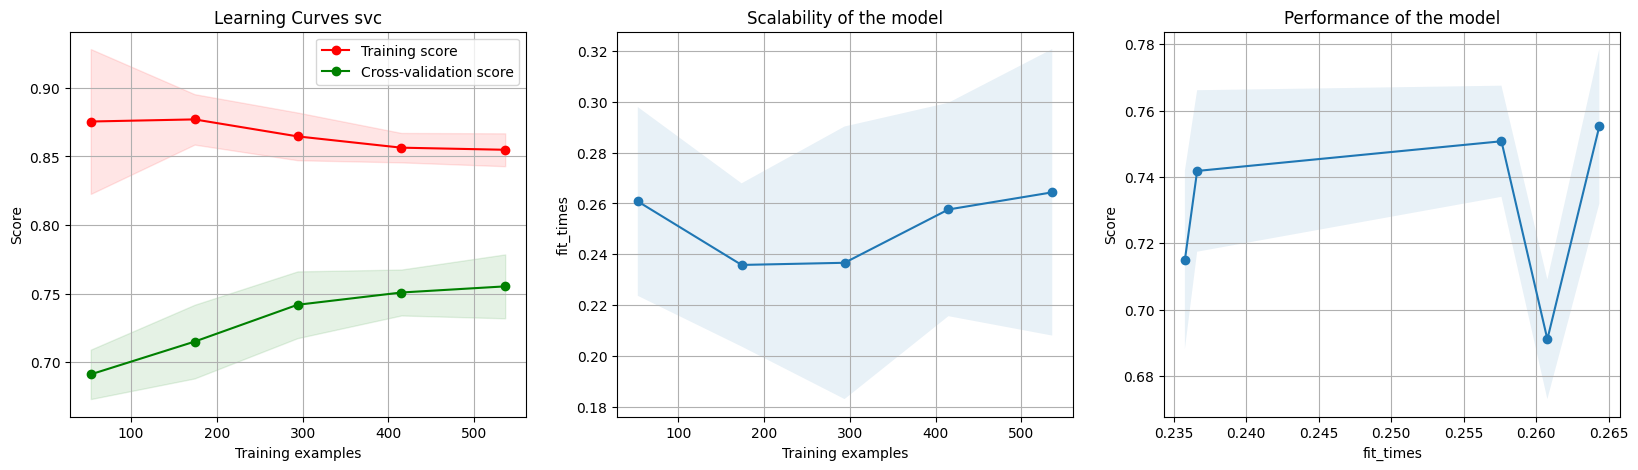

In [ ]:
plot_learning_curve(loaded_best_estimator_round2, 'Learning Curves svc', X_train, y_train, n_jobs=-1)

In [ ]:
print(loaded_best_estimator_round2.score(X_train,y_train))

0.8492537313432836


In [ ]:
print(loaded_complete_grid_round2.best_score_)

0.7555555555555555


<font size=6> **ROUND 3: Random Forest**

In [ ]:
credit_risk_pipeline_2 = Pipeline([
('rare_label_encoder',
RareLabelEncoder(variables=var_rare_labels,replace_with='Rare')),
('one_hot_encoder',
OneHotEncoder(variables=categorical,drop_last= True, ignore_format=True)),
('log_transformer',
LogTransformer(variables = continuous)),
('scalar',
SklearnTransformerWrapper(StandardScaler(),variables=continuous)),
('convert_to_numpy', ConvertToNumpyArray())
])


In [ ]:
credit_risk_pipeline_2_rf = Pipeline([
('rare_label_encoder',
RareLabelEncoder(variables=var_rare_labels,replace_with='Rare')),
('one_hot_encoder',
OneHotEncoder(variables=categorical,drop_last= True, ignore_format=True)),
('log_transformer',
LogTransformer(variables = continuous)),
('scalar',
SklearnTransformerWrapper(StandardScaler(),variables=continuous)),
('convert_to_numpy', ConvertToNumpyArray()),
('rf', RandomForestClassifier(oob_score=True, random_state= 0))
])

In [ ]:
X_train_processed = credit_risk_pipeline_2.fit_transform(X_train)

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable credit_history is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable purpose is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable savings_status is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable personal_status is less than that indicated in n_categories. Thus

In [ ]:
train_scores = []
oob_scores = []
best_oob_score = 0
best_n_estimators = 50

rf = RandomForestClassifier(warm_start=True, random_state=0, oob_score=True)
estimator_range = range(50, 500, 10)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train_processed, y_train)
    train_scores.append(rf.score(X_train_processed, y_train))
    oob_scores.append(rf.oob_score_)
    if rf.oob_score_ > best_oob_score:
        best_n_estimators = n_estimators
        best_oob_score = rf.oob_score_


In [ ]:
print(best_n_estimators)

110


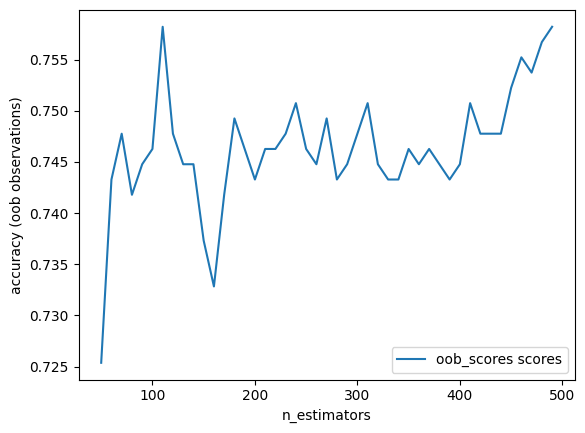

In [ ]:
plt.plot(estimator_range, oob_scores, label="oob_scores scores")
plt.ylabel("accuracy (oob observations)")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

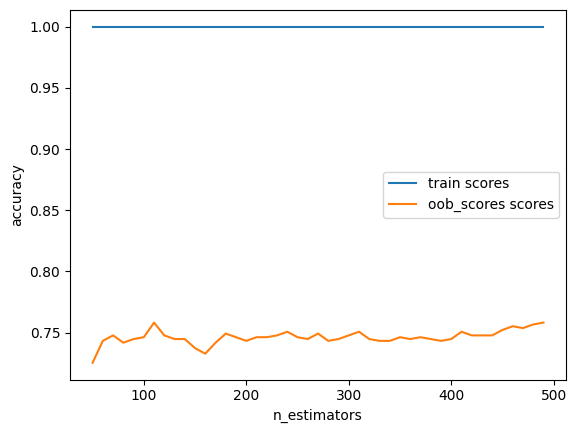

In [ ]:
plt.plot(estimator_range, train_scores, label="train scores")
plt.plot(estimator_range, oob_scores, label="oob_scores scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

In [ ]:
# now we create the grid with all the parameters that we would like to test.

param_grid_3= {
    'rf__n_estimators' :[110],
    'rf__max_features' : ["sqrt", "log2",None],
    'rf__max_depth': np.arange(2,10),
    'rf__min_samples_leaf': np.arange(2,20),
    'rf__max_leaf_nodes': np.arange(2, 20),
    'rf__min_impurity_decrease': loguniform(0.00001, 0.1),
    }



# now we set up the grid search with cross-validation
grid_rf_1 = HalvingRandomSearchCV(credit_risk_pipeline_2_rf, param_grid_3,
                           cv=cv, return_train_score= True,resource='n_samples', random_state=123)

In [ ]:
# fit the model
grid_rf_1.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable credit_history is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable purpose is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable savings_status is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable personal_status is less than that indicated in n_categories. Thus

HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                      estimator=Pipeline(steps=[('rare_label_encoder',
                                                 RareLabelEncoder(variables=['credit_history',
                                                                             'purpose',
                                                                             'savings_status',
                                                                             'personal_status',
                                                                             'other_parties',
                                                                             'other_payment_plans',
                                                                             'job'])),
                                                ('one_hot_encoder',
                                                 OneHotEncoder(drop_last=True,
                                                               ignore_format=True,
                                                               variables=['chec...
                      param_distributions={'rf__max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                           'rf__max_features': ['sqrt', 'log2',
                                                                None],
                                           'rf__max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                           'rf__min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c4568647970>,
                                           'rf__min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                           'rf__n_estimators': [110]},
                      random_state=123)

In [ ]:
grid_rf_1.best_params_

{'rf__max_depth': 5,
 'rf__max_features': None,
 'rf__max_leaf_nodes': 9,
 'rf__min_impurity_decrease': 2.727192594704538e-05,
 'rf__min_samples_leaf': 7,
 'rf__n_estimators': 110}

In [ ]:
file_best_estimator_round3 = save_model_folder / 'rf_round3_best_estimator.pk'
file_complete_grid_round3 = save_model_folder / 'rf_round3_complete_grid.pkl'

In [ ]:
joblib.dump(grid_rf_1.best_estimator_, file_best_estimator_round3)
joblib.dump(grid_rf_1, file_complete_grid_round3)

['/content/drive/MyDrive/AML/data/models/ml_fall_2023/rf_round3_complete_grid.pkl']

In [ ]:
loaded_best_estimator_round3 = joblib.load(file_best_estimator_round3)
loaded_complete_grid_round3 = joblib.load(file_complete_grid_round3)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

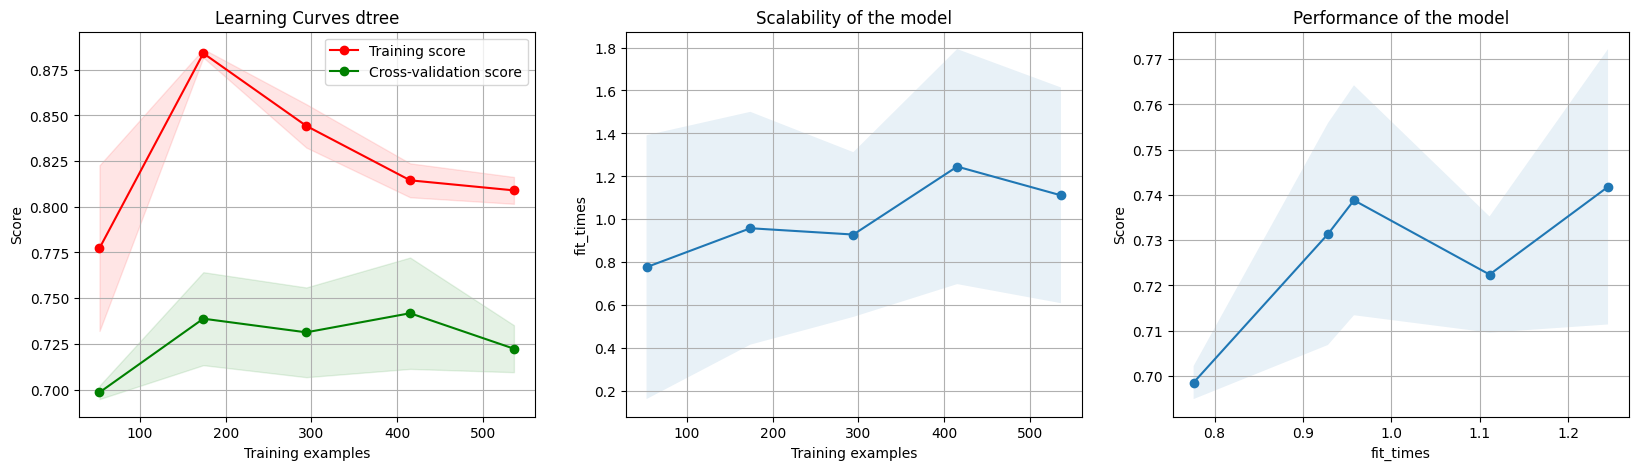

In [ ]:
plot_learning_curve(loaded_best_estimator_round3,
                    'Learning Curves dtree',
                    X_train, y_train, n_jobs=-1)

In [ ]:
#let's check the train scores
print(loaded_best_estimator_round3.score(X_train,y_train))

#let's check the cross validation score
print(loaded_complete_grid_round3.best_score_)

0.8149253731343283
0.7296296296296296


<font size=6>**CONCLUSION**

From the KNN Classification, the accuracy was 72.12%. In logistic regression, the best accuracy was 76.87%. Before, for SVC with RandomSearchCV, we got an accuracy of 76.57%. Here, for SVC with Halving RandomSearchCV, we got an accuracy of 75.56%. For Random Forest, we got an accuracy of 73%. Logistic Regression, Random Forest and SVC outperform KNN Classification. Highest accuracies are seen in SVC and Logistic Regression. There is not that much of a difference between the accuracies them. Since SVC has regularization and margin maximization, I would recommend SVC.

In [ ]:
results = pd.DataFrame(loaded_complete_grid_round3.cv_results_)
results.head()
# sort the results by mean_test_score
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results[[
    'param_rf__max_features',
    'param_rf__max_depth',
    'param_rf__min_samples_leaf',
    'param_rf__max_leaf_nodes',
    'param_rf__min_impurity_decrease',

    'mean_test_score', 'std_test_score', 'mean_train_score'
]].head(20)

,param_rf__max_features,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__max_leaf_nodes,param_rf__min_impurity_decrease,mean_test_score,std_test_score,mean_train_score
0,sqrt,6,4,8,0.000196,0.85,0.122474,0.7750
1,log2,5,3,9,0.000346,0.80,0.187083,0.8625
2,log2,5,3,16,0.002101,0.80,0.187083,0.8625
3,log2,9,3,16,0.00047,0.80,0.187083,0.8625
4,None,3,17,3,0.005487,0.75,0.158114,0.6875
5,sqrt,3,6,5,0.00165,0.75,0.158114,0.6875
6,log2,8,14,8,0.000269,0.75,0.158114,0.6875
7,sqrt,5,8,9,0.001686,0.75,0.158114,0.6875
8,sqrt,7,6,14,0.000017,0.75,0.158114,0.6875
9,sqrt,9,15,2,0.000148,0.75,0.158114,0.6875
